In [1]:
import pandas as pd
import numpy as np
from scipy import *
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In the cell below, I'm going to import the datasets and combine them

In [2]:
# Load the datasets
players_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT8o4nkvbUymRu58VXxfx1Ze3RVs78wfbbc6GdHIbzWn6_AuuJS4vsrrjIEXWMoUE3LOidTidcd_uqt/pub?output=csv')
valuations_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS061Sh3XiRemQxpTOJFtg3q44nTqRJwUL4z2RZ2mhPv41k96eIpsAb6BOEAfdLR3QRFk0_v5dKcaZ5/pub?output=csv')
appearances1 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRlbpb511aHJP63Z8kILaZz2uRyBErrNcMCXAw4roIQCkyBV4-SdSomgy2ZCTZLCuvgY98qwUfmQEEW/pub?output=csv')
appearances2 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSUWINZf2kmCuRskxQKOtaBLcQJtAedmf78NkUWPr4OssyAbD-MbKEB7945bnHXN3yRwSgKXCcSDQa0/pub?output=csv')
appearances3 = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSpmL_xwHxoXRNstiXpau2Go9EqhLAshIvKO6QUwGAo2qe-9LdRff8RYCtMYdY-5aO34L-mKlBSnsv9/pub?output=csv')
appearances_df = pd.concat([appearances1, appearances2, appearances3])

# Filter out rows where 'position' is 'Missing'
players_df = players_df[players_df['position'] != 'Missing']
players_df = players_df[players_df['agent_name'] != 'Missing']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Specify the columns to be one-hot encoded
categorical_columns = ['current_club_domestic_competition_id', 'position', 'agent_name', 'foot', 'country_of_citizenship']

# Apply OneHotEncoder to the categorical columns
encoded_data = encoder.fit_transform(players_df[categorical_columns])

# Get new column names for encoded data
new_columns = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=new_columns)

# Drop original categorical columns and concatenate the new encoded DataFrame
players_df = players_df.drop(columns=categorical_columns).reset_index(drop=True)
players_df_encoded = pd.concat([players_df, encoded_df], axis=1)

# Drop columns that aren't useful
players_df_encoded = players_df_encoded.drop(columns=['city_of_birth', 'country_of_birth', 'image_url', 'url'])

# Aggregate goals, assists, and other stats by player_id
goals_by_player_df = appearances_df.groupby('player_id').agg({'goals': 'sum', 'assists': 'sum',
                                                              'yellow_cards': 'sum', 'red_cards': 'sum',
                                                              'minutes_played': 'sum'}).reset_index()

# Merge the datasets into one comprehensive dataset
final_df = pd.merge(players_df_encoded, goals_by_player_df, on='player_id', how='inner')

# Convert 'date_of_birth' to datetime and calculate age
final_df['date_of_birth'] = pd.to_datetime(final_df['date_of_birth'])
final_df['age'] = (pd.to_datetime('2023-01-01') - final_df['date_of_birth']).astype('<m8[Y]')

# Drop NaN values
final_df = final_df.dropna()

# Display the final, combined DataFrame
print(final_df)


/Users/alaa/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


       player_id first_name   last_name             name  last_season  \
5           4042       Brad       Jones       Brad Jones         2017   
31          8187     Juanmi    Callejón  Juanmi Callejón         2012   
67         18922      Karim     Benzema    Karim Benzema         2022   
82         22860     Jesper      Hansen    Jesper Hansen         2023   
99         27941    Danijel     Subasic  Danijel Subasic         2019   
...          ...        ...         ...              ...          ...   
23628     284732       Ramy  Bensebaini  Ramy Bensebaini         2023   
23629     288499    Ewandro       Costa    Ewandro Costa         2017   
23630     371851       Jaka       Bijol       Jaka Bijol         2023   
23631     586756      Festy     Ebosele    Festy Ebosele         2023   
23633     925584       Axel    Guessand    Axel Guessand         2023   

       current_club_id      player_code date_of_birth    sub_position  \
5                  234       brad-jones    1982-03

### Why these features:
We initially struggled to get the r2 of our models above 10 percent, while this was partially aided by the complex nature of soccer analytics which brings in factors we cant account for like social media notoriety and regional politics, through complex and intentional feature engineering and the meticulous selection of different columns we were able to create a model that had a high r2 and an acceptable mean standard of accuracy. We intially wanted to change this from regression to classification, and create bins with market value ranges, however since our target variable is more continuous we believed that all in all regression was the best tactic here. As noted above and below the features we decided to incorporate were current_club_domestic_citizenship_id, country_of_citizenship_, player_club_domestic_competition_id, foot_, position_ and agent_name (those were our categorical variables that we used one hot encoding for) as well as numerical features like yellow_cards, goals_, assists_, age, minutes_played, height_in_cm, current_club_id, and red_cards. This combination of features is a mix between player charateristics and performance metric which resulted in the highest r2 and mse we could manage. 

In this cell we partition the data in to training and test sets

In [3]:
# Extract the names of the one-hot encoded country columns
one_hot_encoded_columns = [col for col in final_df.columns if 'current_club_domestic_competition_id_' in col]
country_encoded_columns = [col for col in final_df.columns if 'country_of_citizenship_' in col]
playercode_encoded_columns = [col for col in final_df.columns if 'player_club_domestic_competition_id_' in col]
foot_encoded_columns = [col for col in final_df.columns if 'foot_' in col]
position_encoded_columns = [col for col in final_df.columns if 'position_' in col]
agent_encoded_columns = [col for col in final_df.columns if 'agent_name_' in col]


# Partition Data
# Include the one-hot encoded columns in X
X_columns = ['yellow_cards', 'goals', 'assists', 'age', 'minutes_played', 'last_season', 'height_in_cm', 'current_club_id', 'red_cards'] + agent_encoded_columns + foot_encoded_columns + position_encoded_columns + one_hot_encoded_columns + country_encoded_columns + playercode_encoded_columns 

X = final_df[X_columns]
y = final_df['highest_market_value_in_eur']
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)  # 20% of data for testing


Here is our KNN model. We train and test it and print the results.

In [4]:
# Extract the names of the one-hot encoded country columns
one_hot_encoded_columns = [col for col in final_df.columns if 'current_club_domestic_competition_id_' in col]
country_encoded_columns = [col for col in final_df.columns if 'country_of_citizenship_' in col]
playercode_encoded_columns = [col for col in final_df.columns if 'player_club_domestic_competition_id_' in col]
foot_encoded_columns = [col for col in final_df.columns if 'foot_' in col]
position_encoded_columns = [col for col in final_df.columns if 'position_' in col]
agent_encoded_columns = [col for col in final_df.columns if 'agent_name_' in col]


# Partition Data
# Include the one-hot encoded columns in X
X_columns = ['yellow_cards', 'goals', 'assists', 'age', 'minutes_played', 'last_season', 'height_in_cm', 'current_club_id', 'red_cards'] + agent_encoded_columns + foot_encoded_columns + position_encoded_columns + one_hot_encoded_columns + country_encoded_columns + playercode_encoded_columns 

X = final_df[X_columns]
y = final_df['highest_market_value_in_eur']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)  # 20% of data for testing

k = 200  

# Create the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=k)

# Train the model
knn_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_regressor.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)

print("KNN Regression Model Evaluation:")
print(f"Mean Squared Error: {mse_knn}")
print(f"R² Score: {r2_knn}")
print(f"Root Mean Squared Error: {rmse_knn}")


KNN Regression Model Evaluation:
Mean Squared Error: 101306664461467.56
R² Score: 0.3366950416423017
Root Mean Squared Error: 10065121.18463894


This is our Random Forest Regressor model. We print out the evaluations

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming the previous steps have been executed and final_df is ready
# Extract the names of the one-hot encoded country columns
one_hot_encoded_columns = [col for col in final_df.columns if 'current_club_domestic_competition_id_' in col]
country_encoded_columns = [col for col in final_df.columns if 'country_of_citizenship_' in col]
playercode_encoded_columns = [col for col in final_df.columns if 'player_club_domestic_competition_id_' in col]
foot_encoded_columns = [col for col in final_df.columns if 'foot_' in col]
position_encoded_columns = [col for col in final_df.columns if 'position_' in col]
agent_encoded_columns = [col for col in final_df.columns if 'agent_name_' in col]


# Partition Data
# Include the one-hot encoded columns in X
X_columns = ['yellow_cards', 'goals', 'assists', 'age', 'minutes_played', 'last_season', 'height_in_cm', 'current_club_id'] + agent_encoded_columns + foot_encoded_columns + position_encoded_columns + one_hot_encoded_columns + country_encoded_columns + playercode_encoded_columns 

X = final_df[X_columns]
y = final_df['highest_market_value_in_eur']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.19, random_state=43) 

best_mse = float('inf')
best_rf_model = None
best_nestim = 0
# higher estimators tend to have better results
estimators = [80, 140, 240]

for n in estimators:
    model = RandomForestRegressor(n_estimators=n, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    if mse < best_mse:
        best_mse = mse
        best_rf_model = model
        best_nestim = n

    print(f"Model with {n} estimators")
    print(f"Mean Squared Error: {mse:.2f}\n")

# Evaluating the best model
rmse = np.sqrt(mean_squared_error(y_test, best_rf_model.predict(X_test)))
r2 = r2_score(y_test, best_rf_model.predict(X_test))

print("Best Model Evaluation:")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")



Model with 80 estimators
Mean Squared Error: 46659566041260.69

Model with 140 estimators
Mean Squared Error: 46398735121881.07

Model with 240 estimators
Mean Squared Error: 46096998211594.82

Best Model Evaluation:
Root Mean Squared Error: 6789477.020477706
R² Score: 0.6959107578110947


Here is where we calculate the feature importance of our model.

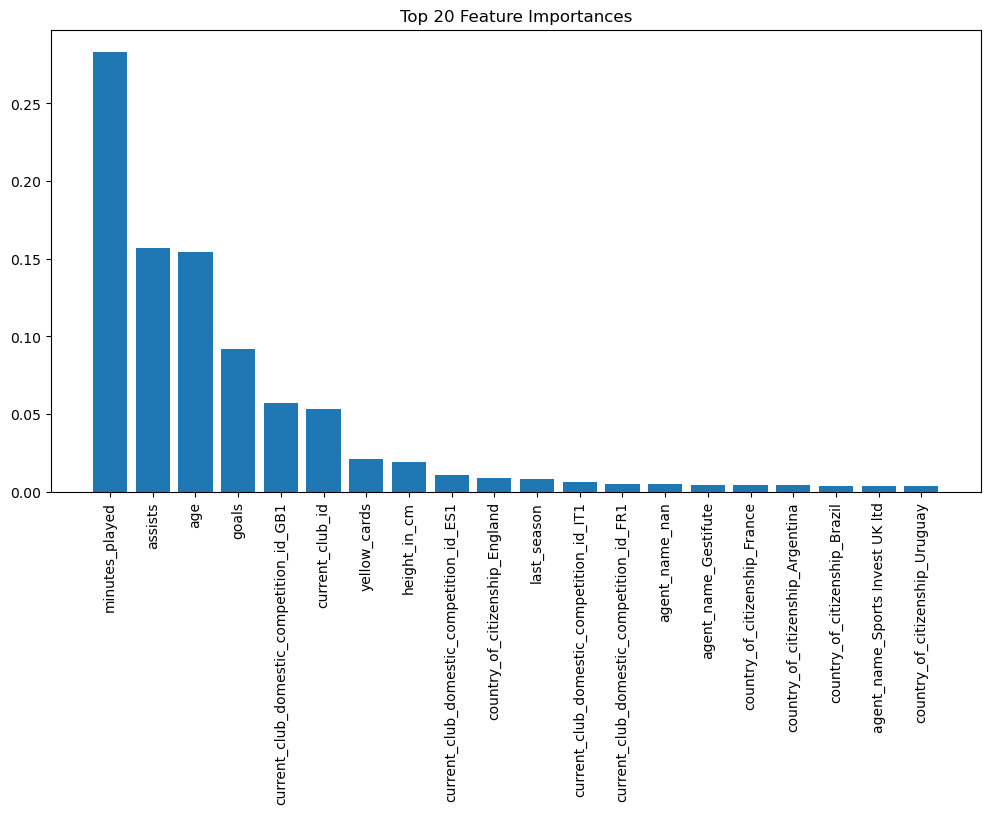

In [6]:
# Calculating Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Selecting the top 20 features
top_n = 20
top_indices = indices[:top_n]

# Plotting
plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(top_n), importances[top_indices], align='center')
plt.xticks(range(top_n), X.columns[top_indices], rotation=90)
plt.show()

This is our SVM model, we train it and print the results.

In [ ]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

# Scaling the code 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=2, scoring='r2', verbose=2)
grid_search.fit(X_train_scaled, y_train)


# Train the model with the best parameters
best_svm_model = grid_search.best_estimator_

# Predict and evaluate
y_pred_best_svm = best_svm_model.predict(X_test_scaled)
mse_best_svm = mean_squared_error(y_test, y_pred_best_svm)
r2_best_svm = r2_score(y_test, y_pred_best_svm)

print("Best SVM Model Evaluation:")
print(f"Mean Squared Error: {mse_best_svm}")
print(f"R² Score: {r2_best_svm}")


Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time= 2.3min
[CV] END ....................C=0.1, epsilon=0.01, kernel=rbf; total time= 2.3min
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time= 2.0min
[CV] END .................C=0.1, epsilon=0.01, kernel=linear; total time= 1.9min
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time= 1.9min
[CV] END ...................C=0.1, epsilon=0.01, kernel=poly; total time= 1.9min
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time= 2.4min
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time= 2.3min
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time= 2.0min
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time= 2.0min
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time= 1.9min
[CV] END ....................C=0.1, epsilon=0.1,